In [907]:
import cv2
import numpy as np
import seaborn as sns
from time import time
from tqdm import tqdm
import h5py

from robust_line_based_estimator.line_matcher import LineMatcher
from robust_line_based_estimator.vp_matcher import vp_matching
from robust_line_based_estimator.visualization import plot_images, plot_lines, plot_color_line_matches, plot_vp

In [908]:
# Parameters
matcher_type = "lbd" # "sold2"
dataset_path = "/media/hdd2tb/datasets/RANSAC-Tutorial-Data/train"
output_path = "."
threshold = 3 # Threshold in pixels
scenes = [ "buckingham_palace" ]

In [909]:
# Initializing the line matcher
if matcher_type == "lbd":
    # LSD+LBD matcher
    matcher = LineMatcher(line_detector='lsd', line_matcher='lbd')
else:
    # SOLD2 matcher
    conf = {
        'sold2': {
            'ckpt_path': '../third_party/SOLD2/pretrained_models/sold2_wireframe.tar',
            'device': 'cpu'
        }
    }
    matcher = LineMatcher(line_detector='sold2', line_matcher='sold2', conf=conf)

In [910]:
def load_h5(filename):
    '''Loads dictionary from hdf5 file'''
    dict_to_load = {}
    try:
        with h5py.File(filename, 'r') as f:
            keys = [key for key in f.keys()]
            for key in keys:
                dict_to_load[key] = f[key][()]
    except:
        print('Cannot find file {}'.format(filename))
    return dict_to_load

def append_h5(dict_to_save, filename):
    '''Saves dictionary to HDF5 file'''

    with h5py.File(filename, 'a') as f:
        for key in dict_to_save:
            f.create_dataset(key, data=dict_to_save[key])

def read_h5(key, filename):
    '''Saves dictionary to HDF5 file'''

    with h5py.File(filename, 'a') as f:
        if key in f.keys():
            return np.array(f.get(key))
        else:
            return None

def convert_ms_lines(ms_lines):
    np_ms_lines = np.zeros((len(ms_lines), 5 * 6))
    for row_idx in range(np_ms_lines.shape[0]):
        for item_idx in range(5):
            np_ms_lines[row_idx, 6 * item_idx : 6 * (item_idx + 1)] = ms_lines[row_idx][item_idx][1]
    return np_ms_lines

def parse_ms_lines(np_ms_lines):    
    ms_lines = []
    for row_idx in range(np_ms_lines.shape[0]):
        inner_list = []
        for item_idx in range(5):
            inner_list.append((item_idx, np_ms_lines[row_idx, 6 * item_idx : 6 * (item_idx + 1)]))
        ms_lines.append(inner_list)
    return ms_lines

In [911]:
def normalize_keypoints(keypoints, K):
    '''Normalize keypoints using the calibration data.'''

    C_x = K[0, 2]
    C_y = K[1, 2]
    f_x = K[0, 0]
    f_y = K[1, 1]
    keypoints = (keypoints - np.array([[C_x, C_y]])) / np.array([[f_x, f_y]])

    return keypoints

def reprojection_errors(keypoints1, keypoints2, points3d, P1, P2):
    if points3d.shape[1] == 3:
        points3d = np.concatenate((points3d, np.ones((points3d.shape[0], 1), np.float64)), axis=1)

    # Projecting the 3D points in the images
    projections1 = points3d @ P1.T
    projections2 = points3d @ P2.T

    # Homogeneous division
    projections1 = projections1[:, :2] / projections1[:, 2, None]
    projections2 = projections2[:, :2] / projections2[:, 2, None]

    # Calculating the difference between the original keypoints and the projections
    diff1 = keypoints1 - projections1
    diff2 = keypoints2 - projections2    
    
    norm1 = np.linalg.norm(diff1, axis=1)
    norm2 = np.linalg.norm(diff2, axis=1)
    avg_norms = 0.5 * (norm1 + norm2)
    return avg_norms

def linear_eigen_triangulation(u1, P1, u2, P2, max_coordinate_value=1.e16):
    """
    Linear Eigenvalue based (using SVD) triangulation.
    Wrapper to OpenCV's "triangulatePoints()" function.
    Relative speed: 1.0
    
    (u1, P1) is the reference pair containing normalized image coordinates (x, y) and the corresponding camera matrix.
    (u2, P2) is the second pair.
    "max_coordinate_value" is a threshold to decide whether points are at infinity
    
    u1 and u2 are matrices: amount of points equals #rows and should be equal for u1 and u2.
    
    The status-vector is based on the assumption that all 3D points have finite coordinates.
    """
    x = cv2.triangulatePoints(P1[0:3, 0:4], P2[0:3, 0:4], u1.T, u2.T)    # OpenCV's Linear-Eigen triangl
    
    x[0:3, :] /= x[3:4, :]    # normalize coordinates
    x_status = (np.max(abs(x[0:3, :]), axis=0) <= max_coordinate_value)    # NaN or Inf will receive status False
    
    return x[0:3, :].T.astype(np.float64), x_status

def polynomial_triangulation(u1, P1, u2, P2):
    """
    Polynomial (Optimal) triangulation.
    Uses Linear-Eigen for final triangulation.
    Relative speed: 0.1
    
    (u1, P1) is the reference pair containing normalized image coordinates (x, y) and the corresponding camera matrix.
    (u2, P2) is the second pair.
    
    u1 and u2 are matrices: amount of points equals #rows and should be equal for u1 and u2.
    
    The status-vector is based on the assumption that all 3D points have finite coordinates.
    """
    P1_full = np.eye(4); P1_full[0:3, :] = P1[0:3, :]    # convert to 4x4
    P2_full = np.eye(4); P2_full[0:3, :] = P2[0:3, :]    # convert to 4x4
    P_canon = P2_full.dot(cv2.invert(P1_full)[1])    # find canonical P which satisfies P2 = P_canon * P1
    
    # "F = [t]_cross * R" [HZ 9.2.4]; transpose is needed for numpy
    F = np.cross(P_canon[0:3, 3], P_canon[0:3, 0:3], axisb=0).T
    
    # Other way of calculating "F" [HZ (9.2)]
    #op1 = (P2[0:3, 3:4] - P2[0:3, 0:3] .dot (cv2.invert(P1[0:3, 0:3])[1]) .dot (P1[0:3, 3:4]))
    #op2 = P2[0:3, 0:4] .dot (cv2.invert(P1_full)[1][0:4, 0:3])
    #F = np.cross(op1.reshape(-1), op2, axisb=0).T
    
    # Project 2D matches to closest pair of epipolar lines
    u1_new, u2_new = cv2.correctMatches(F, u1.reshape(1, len(u1), 2), u2.reshape(1, len(u1), 2))
    
    # For a purely sideways trajectory of 2nd cam, correctMatches() returns NaN for all possible points!
    if np.isnan(u1_new).all() or np.isnan(u2_new).all():
        F = cv2.findFundamentalMat(u1, u2, cv2.FM_8POINT)[0]    # so use a noisy version of the fund mat
        u1_new, u2_new = cv2.correctMatches(F, u1.reshape(1, len(u1), 2), u2.reshape(1, len(u1), 2))
    
    # Triangulate using the refined image points
    return linear_eigen_triangulation(u1_new[0], P1, u2_new[0], P2)    # TODO: replace with linear_LS: better results for points not at Inf

In [912]:
def get_implicit_line(endpoint1, endpoint2):
    v = endpoint2 - endpoint1
    v /= np.linalg.norm(v)
    n = [-v[1], v[0]]
    c = -n[0] * endpoint1[0] - n[1] * endpoint1[1]
    return np.array([n[0], n[1], c])

def get_line_junctions(m_lines1, m_lines2):
    num_matches = m_lines1.shape[0]

    keypoints1 = []
    keypoints2 = []
    for line_idx1 in range(num_matches - 1):
        # Line in the source image
        line11 = get_implicit_line(m_lines1[line_idx1][0][:], m_lines1[line_idx1][1][:])
        # Line in the destination image
        line21 = get_implicit_line(m_lines2[line_idx1][0][:], m_lines2[line_idx1][1][:])

        for line_idx2 in range(line_idx1 + 1, num_matches):
            # Line in the source image
            line12 = get_implicit_line(m_lines1[line_idx2][0][:], m_lines1[line_idx2][1][:])
            # Line in the destination image
            line22 = get_implicit_line(m_lines2[line_idx2][0][:], m_lines2[line_idx2][1][:])

            # Intersection in the source image
            intersection1 = np.cross(line11, line12)
            intersection1 /= intersection1[2]
            # Intersection in the destination image
            intersection2 = np.cross(line21, line22)
            intersection2 /= intersection2[2]
            # Save the junctions
            keypoints1.append(intersection1[:2])
            keypoints2.append(intersection2[:2])
    return np.array(keypoints1), np.array(keypoints2)

In [913]:
def processingScene(dataset_path, feature_matches, K1_K2, R, T, matcher, linefile_path, matchfile_path, threshold, visualize=False):
    for k, m in tqdm(feature_matches.items()):
        img_id0 = k.split('-')[0]
        img_id1 = k.split('-')[1]

        img0 = cv2.imread(f"{dataset_path}/images/{img_id0}.jpg", 0)
        img1 = cv2.imread(f"{dataset_path}/images/{img_id1}.jpg", 0)

        ## Detecting line segments in the first image
        features0_segments = read_h5(f"img-{img_id0}-line-segments", linefile_path)
        features0_descs = read_h5(f"img-{img_id0}-descriptor", linefile_path)
        features0_ms_lines = read_h5(f"img-{img_id0}-ms_lines", linefile_path)
        if features0_segments is None:
            features0 = matcher.detect_and_describe_lines(img0)
            append_h5({f"img-{img_id0}-line-segments": features0["line_segments"],
                f"img-{img_id0}-descriptor": features0["descriptor"], 
                f"img-{img_id0}-ms_lines": convert_ms_lines(features0["ms_lines"])}, 
                linefile_path)
        else:
            features0 = { "line_segments": features0_segments, 
                "descriptor": features0_descs,
                "ms_lines": parse_ms_lines(features0_ms_lines) }
         
        # Detecting line segments in the second image
        features1_segments = read_h5(f"img-{img_id1}-line-segments", linefile_path)
        features1_descs = read_h5(f"img-{img_id1}-descriptor", linefile_path)
        features1_ms_lines = read_h5(f"img-{img_id1}-ms_lines", linefile_path)
        if features1_segments is None:
            features1 = matcher.detect_and_describe_lines(img1)
            append_h5({f"img-{img_id1}-line-segments": features1["line_segments"],
                f"img-{img_id1}-descriptor": features1["descriptor"], 
                f"img-{img_id1}-ms_lines": convert_ms_lines(features1["ms_lines"])}, 
                linefile_path)
        else:
            features1 = { "line_segments": features1_segments, 
                "descriptor": features1_descs,
                "ms_lines": parse_ms_lines(features1_ms_lines) }

        if visualize:
            # Display the detections
            plot_images([img0, img1], ['Detections 0', 'Detections 1'])
            plot_lines([features0["line_segments"][:, :, [1, 0]], features1["line_segments"][:, :, [1, 0]]])

        ## Matching
        m_lines0 = read_h5(f"{img_id0}-{img_id1}-m_lines0", matchfile_path)
        m_lines1 = read_h5(f"{img_id0}-{img_id1}-m_lines1", matchfile_path)
        if m_lines0 is None:
            _, m_lines0, m_lines1 = matcher.match_lines(img0, img1, features0, features1)
            append_h5({f"{img_id0}-{img_id1}-m_lines0": m_lines0,
                f"{img_id0}-{img_id1}-m_lines1": m_lines1}, 
                matchfile_path)

        if visualize:
            # Plot the matches
            plot_images([img0, img1], ['Matches 0', 'Matches 1'])
            plot_color_line_matches([m_lines0[:, :, [1, 0]], m_lines1[:, :, [1, 0]]])

        # Get all possible line junctions
        keypoints1, keypoints2 = get_line_junctions(m_lines0, m_lines1)

        # Normalize the obtained keypoints by the camera matrix
        K1 = K1_K2[k][0][0]
        K2 = K1_K2[k][0][1]
        kp1n = normalize_keypoints(keypoints1, K1).astype(np.float64)
        kp2n = normalize_keypoints(keypoints2, K2).astype(np.float64)

        # Normalizing the threshold by the camera matrices
        normalized_threshold = threshold / (0.25 * (K1[0, 0] + K1[1, 1] + K2[0, 0] + K2[1, 1]))

        # Composing the projection matrices from the rotations and translations
        R1 = R[img_id0]
        R2 = R[img_id1]
        T1 = T[img_id0]
        T2 = T[img_id1]
        
        P1 = np.concatenate([R1, T1], axis=1)
        P2 = np.concatenate([R2, T2], axis=1)

        # Checking each point's consistency with the camera poses by
        # triangulating them and, then, calculating the re-projection error.
        # for point_idx in range(kp1n.shape[0]):
        points3d, status = polynomial_triangulation(kp1n, P1, kp2n, P2)
        errors = reprojection_errors(kp1n, kp2n, points3d, P1, P2)

        inlier_mask = errors < normalized_threshold
        
        print(inlier_mask)


## Line detection and description

  0%|          | 1/98263 [00:00<24:18:56,  1.12it/s]

[False False False ... False False False]
Computing LBD matching with ARPACK adjacenceVec size: [18443701 x 1]


  0%|          | 2/98263 [00:10<166:31:50,  6.10s/it]

[ True  True  True ... False False False]
Computing LBD matching with ARPACK adjacenceVec size: [522436650 x 1]


/tmp/ipykernel_1242229/3835735283.py:27: RuntimeWarning: divide by zero encountered in true_divide
  intersection1 /= intersection1[2]
/tmp/ipykernel_1242229/3835735283.py:27: RuntimeWarning: invalid value encountered in true_divide
  intersection1 /= intersection1[2]
  0%|          | 3/98263 [00:39<455:58:07, 16.71s/it]

[False False False ... False False False]
Computing LBD matching with ARPACK adjacenceVec size: [155364378 x 1]


  0%|          | 4/98263 [00:56<449:47:51, 16.48s/it]

[False False False ... False False False]


  0%|          | 4/98263 [01:10<479:21:16, 17.56s/it]

Computing LBD matching with ARPACK adjacenceVec size: [64803420 x 1]


KeyboardInterrupt: 

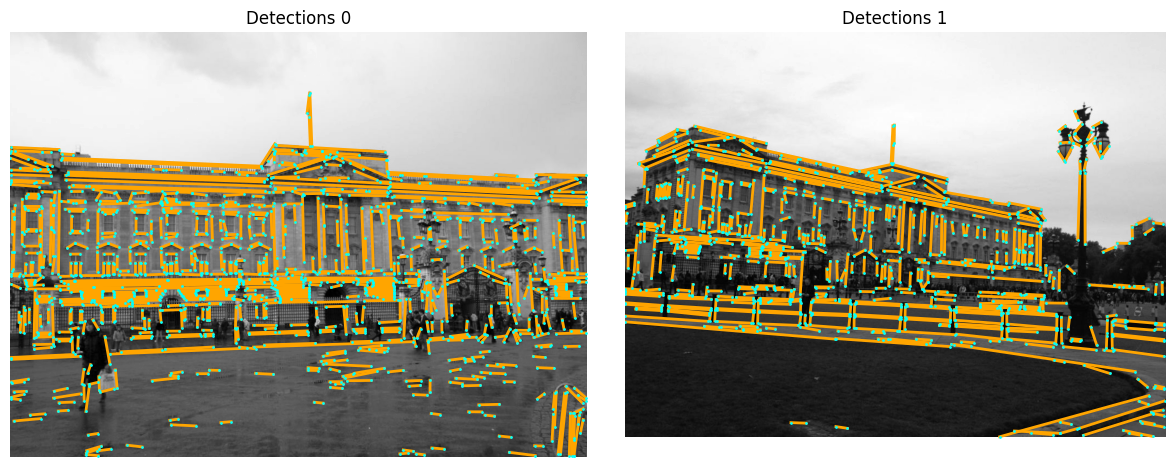

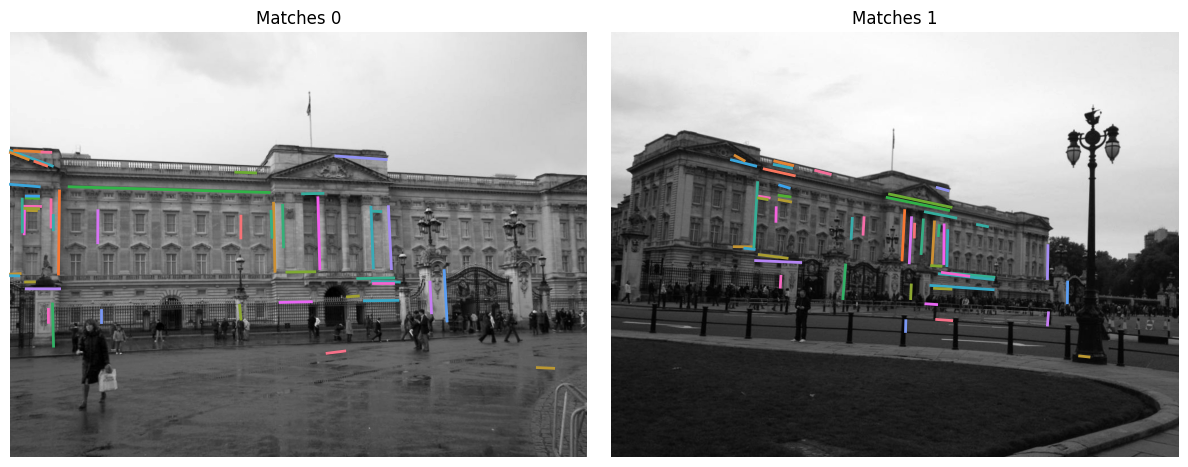

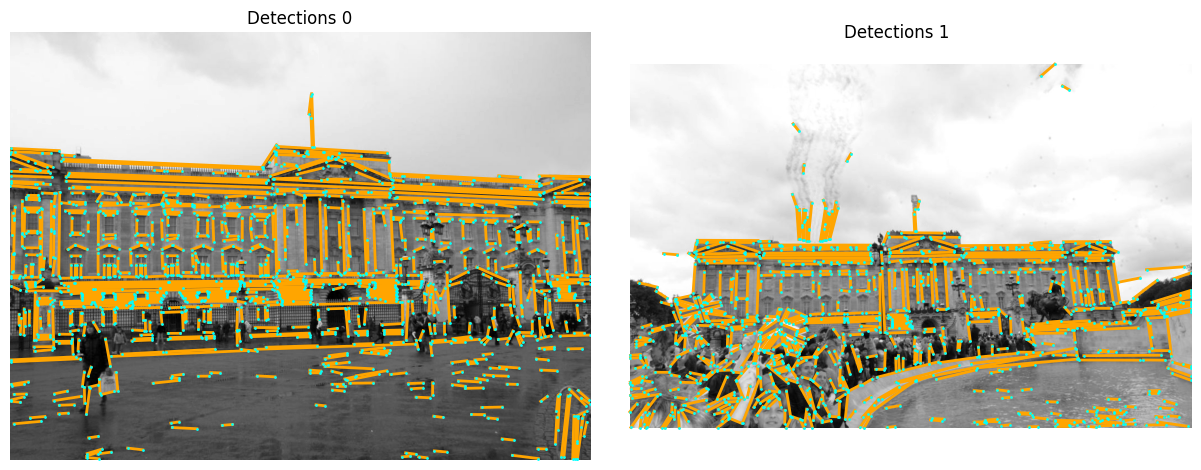

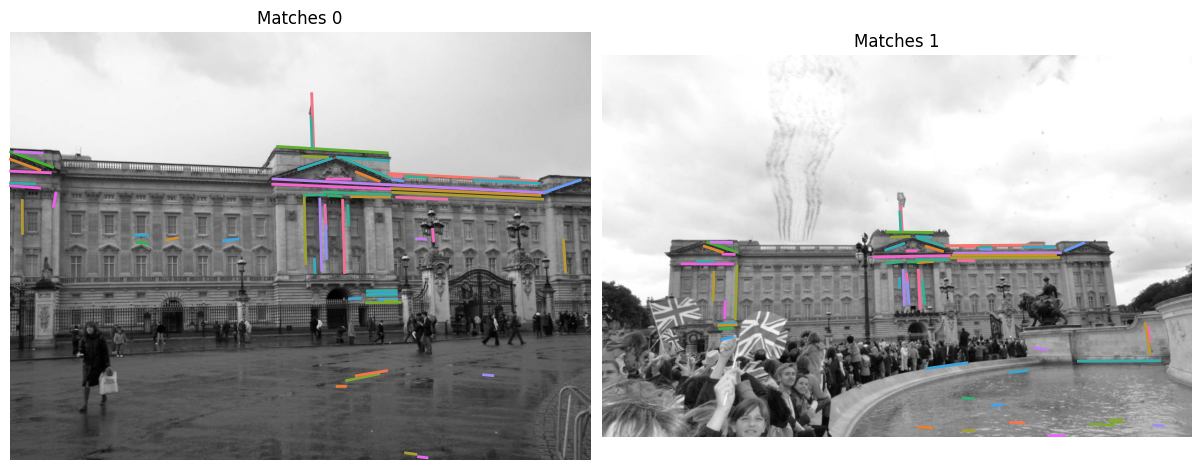

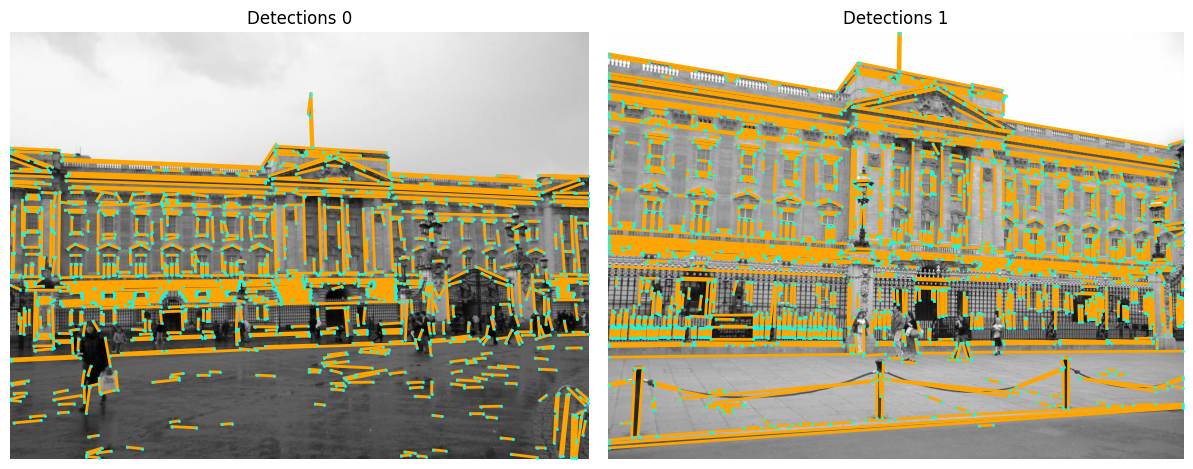

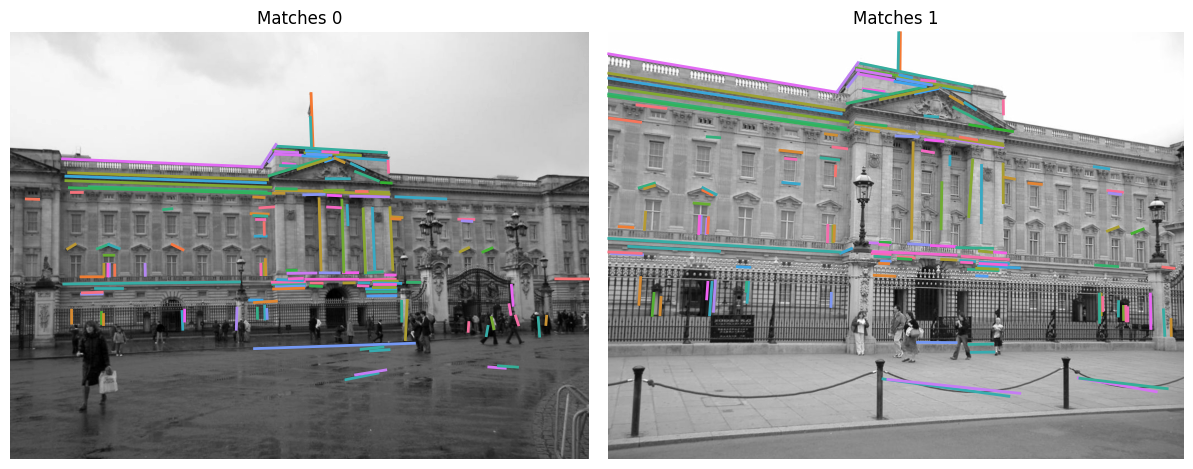

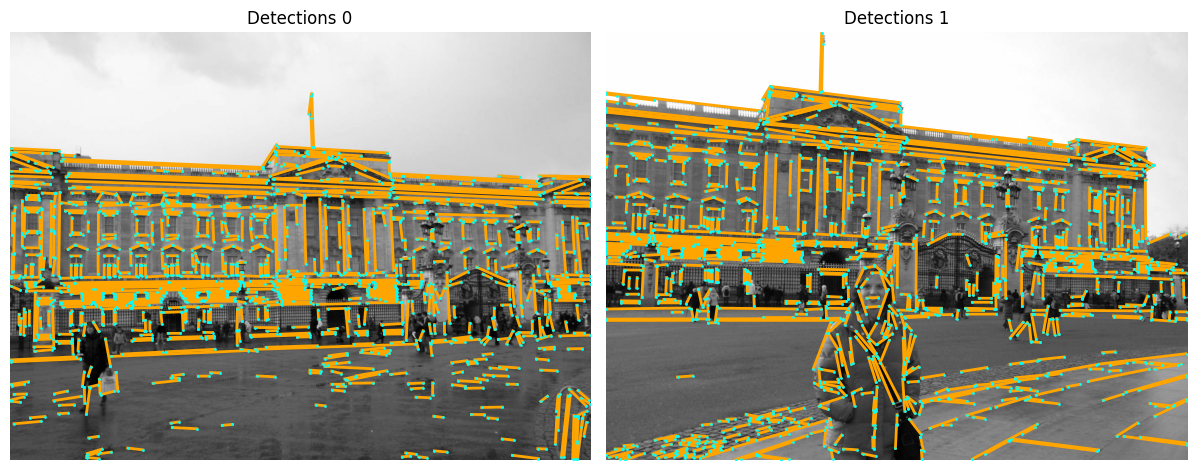

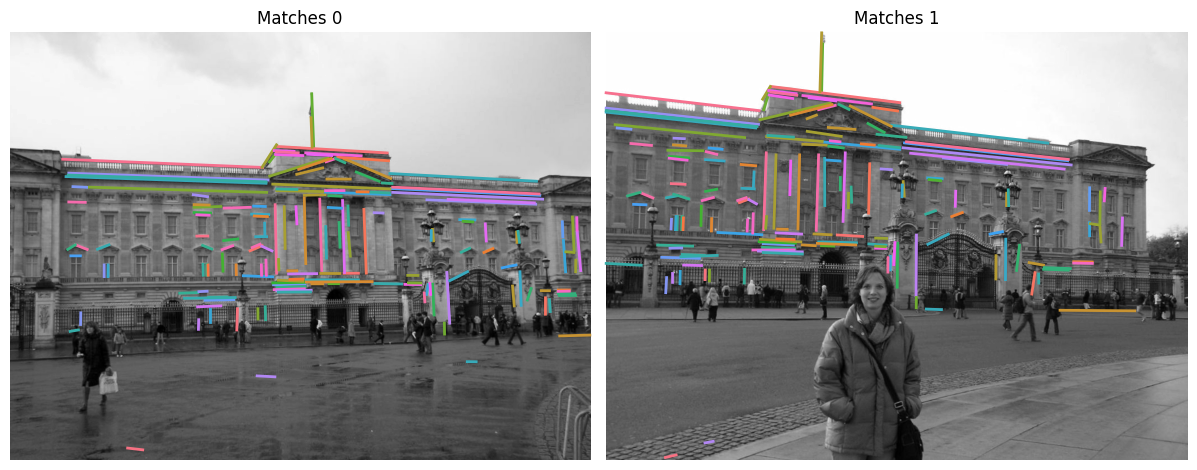

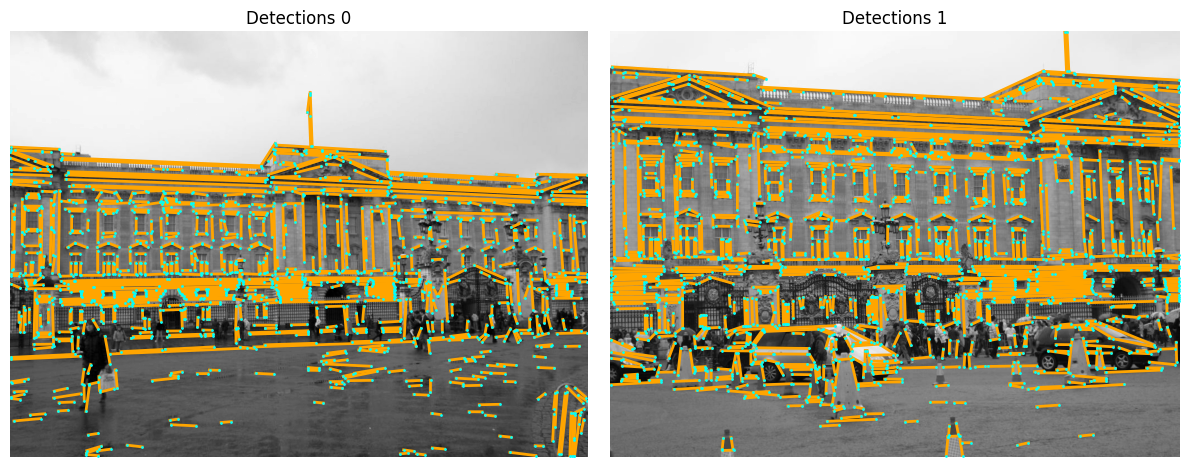

In [914]:
for scene in scenes:
    # Loading the camera parameters and the ground truth pose
    # K1_K2 = load_h5(f'{dataset_path}/{scene}/K1_K2.h5')
    # R = load_h5(f'{dataset_path}/{scene}/R.h5')
    # T = load_h5(f'{dataset_path}/{scene}/T.h5')
    # feature_matches = load_h5(f'{dataset_path}/{scene}/matches.h5')
    # Iterating through the image pairs in the scene
    processingScene(f'{dataset_path}/{scene}', 
        feature_matches,
        K1_K2, 
        R, 
        T, 
        matcher, 
        f"{output_path}/lines_{scene}.h5", 
        f"{output_path}/matches_{scene}.h5", 
        threshold,
        visualize=True)
    